In [1]:
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [2]:
def load_texts(local_Illiad: str = '../data/Homer_Iliad.txt',
               local_Odyssey: str = '../data/Homer_Odyssey.txt',):
    """Load Wonderland and Looking-Glass texts from disk.

    Parameters
    ----------
    local_Illiad : str
        Path to Illiad text file. Defaults to '../data/Homer_Illiad.txt'.
    local_Odyssey : str
        Path to Odyssey text file. Defaults to '../data/Homer_Odyssey.txt'.

    Returns
    -------
    tuple[str, str]
        (illiad_text, odyssey_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1, p2 = Path(local_Illiad), Path(local_Odyssey)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Homer_Illiad.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'Homer_Odyssey.txt' at this path or update load_texts(...)."
        )

    # Read the files (UTF-8; ignore undecodable bytes to stay robust)
    illiad   = p1.read_text(encoding='utf-8', errors='ignore')
    odyssey = p2.read_text(encoding='utf-8', errors='ignore')
    return illiad, odyssey

In [3]:
def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('Translated by Samuel Butler')
    end   = text.find('THE END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')


# -------- Tokenization helpers (simple) --------

WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())

def loadDiniveWords(local_actionWords: str = '../data/divineWords.txt'):
    p1 = Path(local_actionWords)

    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'actionWords.txt' at this path or update load_texts(...)."
        )

    actionWords = p1.read_text(encoding='utf-8', errors='ignore')
    actionWords_normalized = normalize(actionWords)
    actionWords_words = words(actionWords_normalized)
    actionWords_hashmap = {word: 0 for word in actionWords_words}
    return actionWords_hashmap

def split_into_chapters(text: str, delimiter: str = "----------------------------------------------------------------------"):
    """Split text into chapters based on delimiter."""
    chapters = text.split(delimiter)
    # Filter out empty chapters
    return [ch.strip() for ch in chapters if ch.strip()]

def count_divine_words_by_chapter(chapters: list, divine_words_set: set) -> tuple:
    """Count divine words in each chapter and return both raw counts and normalized rates."""
    chapter_counts = []
    chapter_rates = []

    for chapter in chapters:
        chapter_words = words(chapter)
        total_words = len(chapter_words)

        divine_count = sum(1 for word in chapter_words if word in divine_words_set)
        chapter_counts.append(divine_count)

        # Calculate rate per 1000 words (to make numbers more readable)
        if total_words > 0:
            rate = (divine_count / total_words) * 1000
        else:
            rate = 0
        chapter_rates.append(rate)

    return chapter_counts, chapter_rates

def merge_god_variants(word_hash: dict) -> dict:
    """Merge 'god' and 'gods' into a single 'god/gods' entry."""
    merged = word_hash.copy()

    god_count = merged.get('god', 0) + merged.get('gods', 0)

    if god_count >= 0:
        merged['god/gods'] = god_count

    if 'god' in merged:
        del merged['god']
    if 'gods' in merged:
        del merged['gods']


    return merged

def find_word_snippets(text: str, target_word: str, context_words: int = 20, max_snippets: int = 20) -> list:
    """Find snippets around occurrences of a target word.

    Parameters
    ----------
    text : str
        The full text to search.
    target_word : str
        Word to find (case-insensitive).
    context_words : int
        Number of words before/after to include.
    max_snippets : int
        Maximum number of snippets to return.

    Returns
    -------
    list[str]
        List of snippets with target word highlighted.
    """
    words_list = words(text)
    snippets = []

    for i, word in enumerate(words_list):
        if word == target_word.lower():
            # Get context window
            start = max(0, i - context_words)
            end = min(len(words_list), i + context_words + 1)

            # Extract snippet
            snippet_words = words_list[start:end]
            # Highlight target word
            snippet_words[i - start] = f"**{snippet_words[i - start].upper()}**"

            snippet = ' '.join(snippet_words)
            snippets.append(snippet)

            if len(snippets) >= max_snippets:
                break

    return snippets

In [4]:
# Load raw texts
illiad_raw, odyssey_raw = load_texts()

# Normalize for tokenization
illiad = normalize(illiad_raw)
odyssey = normalize(odyssey_raw)

illiad_hash = loadDiniveWords()
odyssey_hash = loadDiniveWords()

print(f"Illiad chars: {len(illiad):,} | Odyssey chars: {len(odyssey):,}")

illiad_words = words(illiad)
odyssey_words = words(odyssey)

Illiad chars: 806,725 | Odyssey chars: 609,794


In [5]:
# Filling the hashmap of illiad
for word in illiad_words:
    if word in illiad_hash:
        illiad_hash[word] += 1

# Filling the hashmap of odyssey
for word in odyssey_words:
    if word in odyssey_hash:
        odyssey_hash[word] += 1

# Merge god/gods in the original hashmaps before counting
illiad_hash = merge_god_variants(illiad_hash)
odyssey_hash = merge_god_variants(odyssey_hash)

# Printing the illiad hash
print("illiad words:")
for word, value in illiad_hash.items():
    if value > 0:
        print(word, value)

print("odyssey words:")
# Printing the odyssey hash
for word, value in odyssey_hash.items():
    if value > 0:
        print(word, value)

illiad words:
divine 3
fate 31
destiny 1
omen 6
prayer 30
sacrifice 27
altar 8
heaven 148
zeus 1
apollo 139
hades 47
nymph 5
muse 1
god/gods 360
odyssey words:
divine 9
fate 13
destiny 1
omen 7
prophecy 4
prayer 14
sacrifice 25
altar 7
heaven 165
apollo 28
hades 30
circe 30
calypso 33
nymph 7
muse 5
god/gods 267


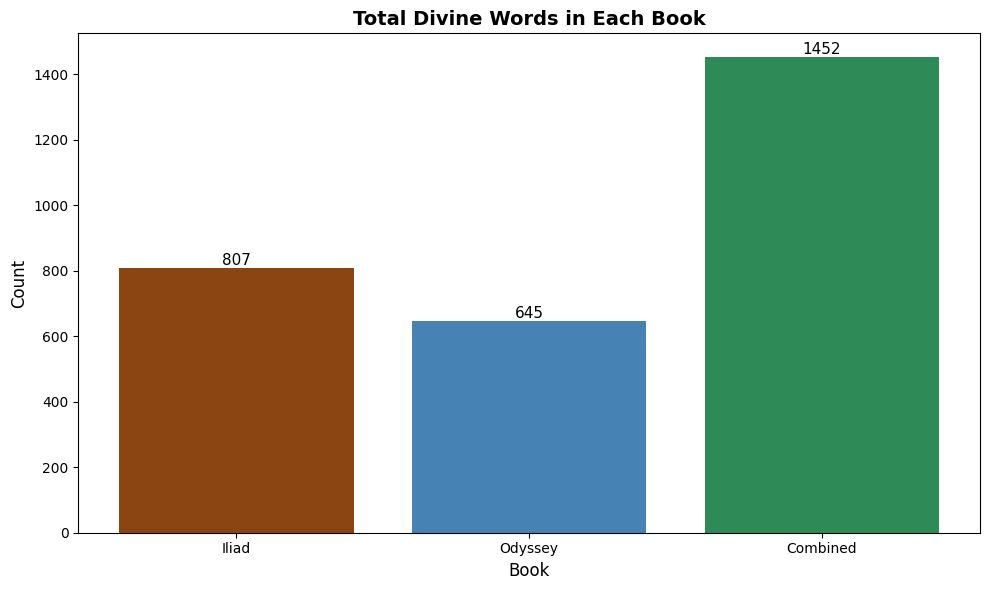

Last Iliad chapter preview:
BOOK XXIV

The assembly now broke up and the people went their ways each to
his own ship. There they made ready their supper, and then bethought
them of the blessed boon of sleep; but Achilles still wept for thinking
of his dear comrade, and sleep, before whom all things bow, could
take no hold upon him. This way and that did he turn as he yearned
after the might and manfulness of Patroclus; he thought of all they
had done together, and all they had gone through both on the field
of battle and o

Last Odyssey chapter preview:
BOOK XXIV

Then Mercury of Cyllene summoned the ghosts of the suitors, and in
his hand he held the fair golden wand with which he seals men's eyes
in sleep or wakes them just as he pleases; with this he roused the
ghosts and led them, while they followed whining and gibbering behind
him. As bats fly squealing in the hollow of some great cave, when
one of them has fallen out of the cluster in which they hang, even
so did the ghosts whine

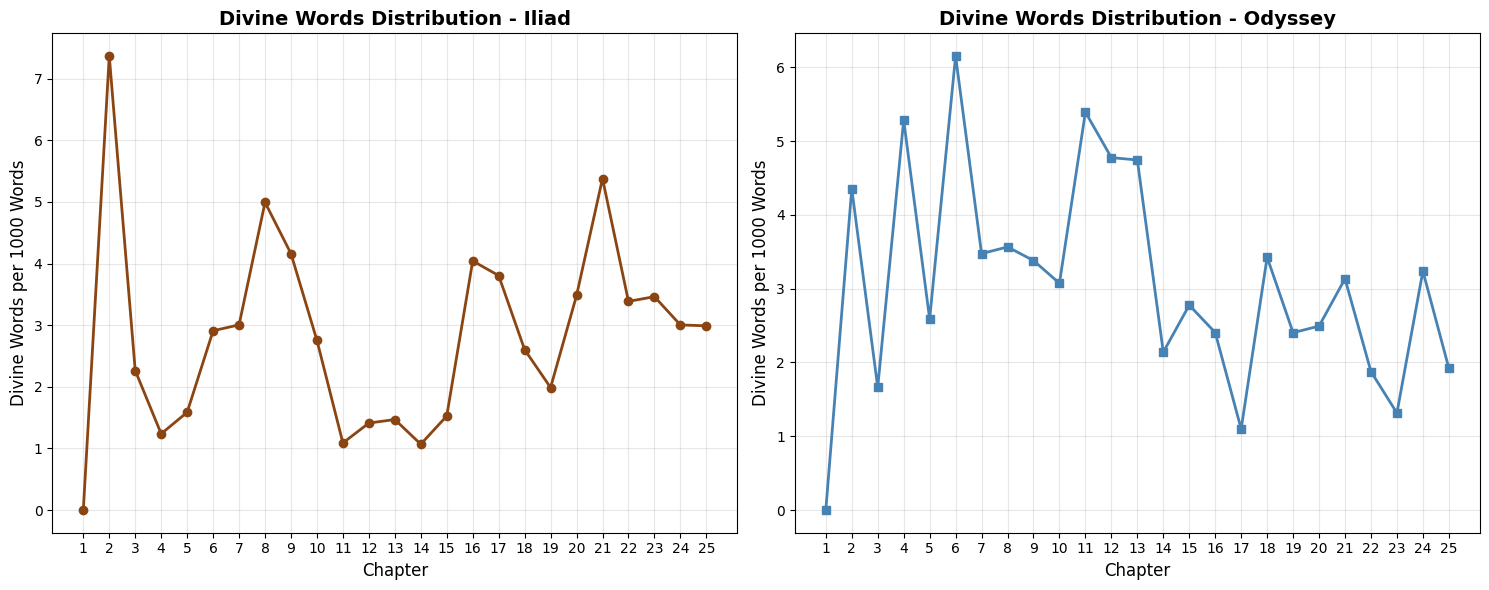

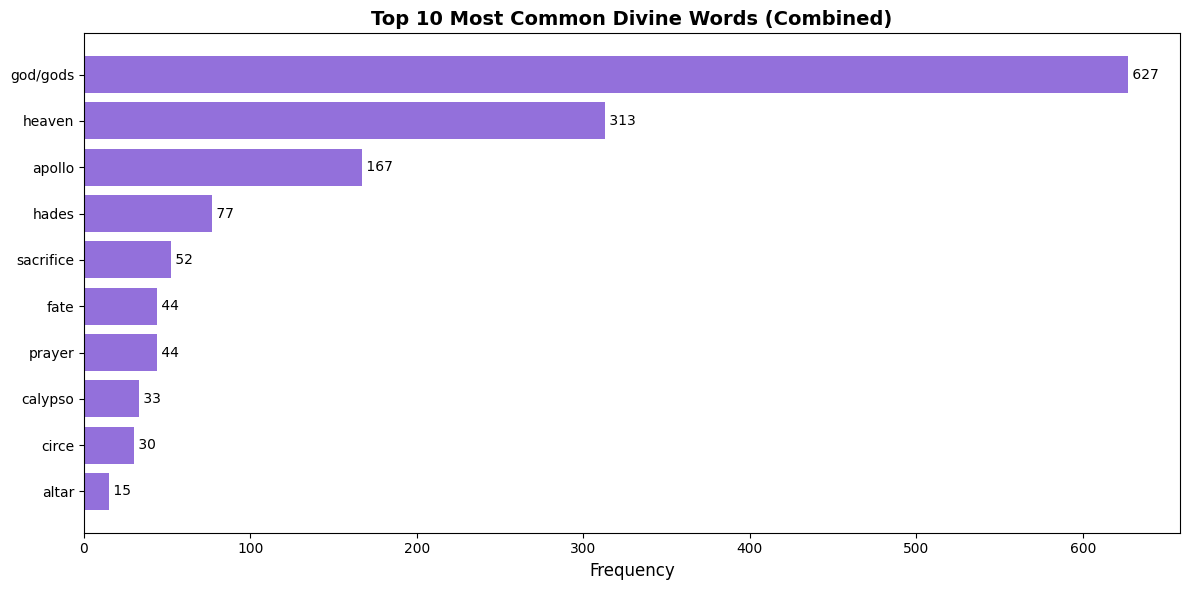

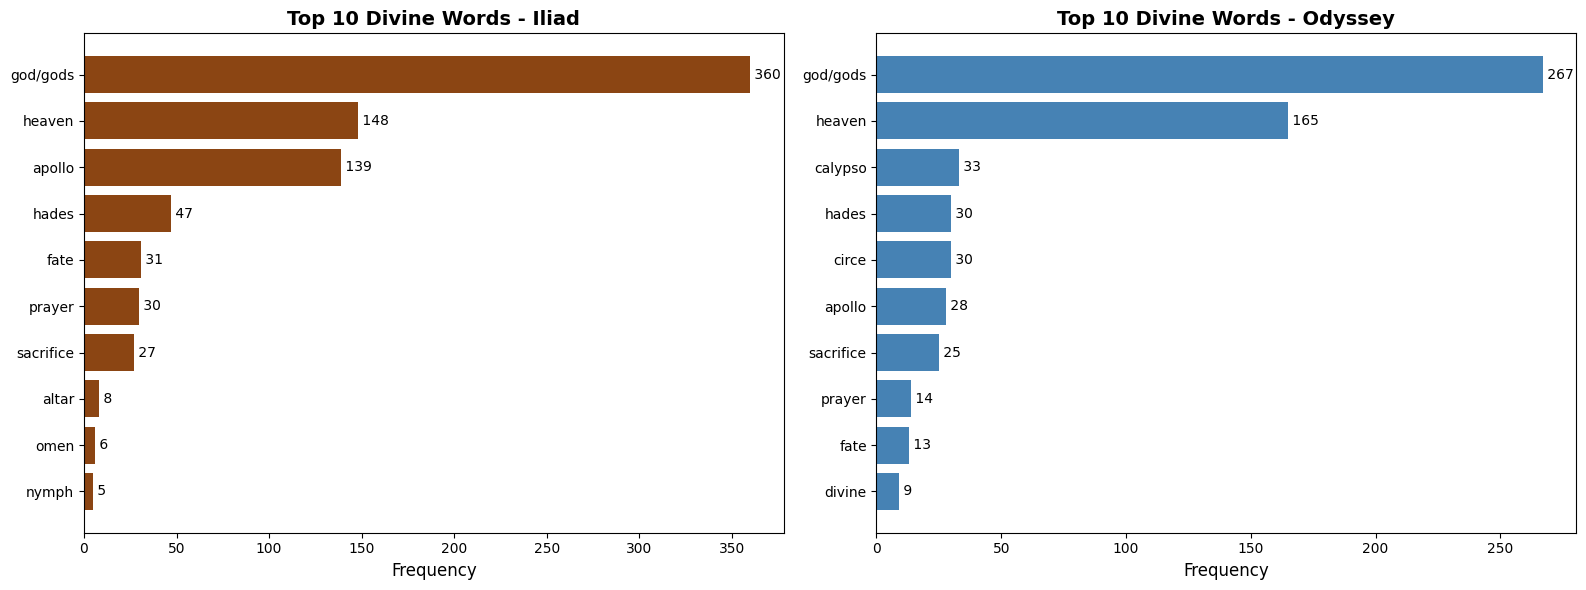

ILIAD - Apollo mentions (found 20):

[1] ...free his daughter and had brought with him a great ransom moreover he bore in his hand the sceptre of **APOLLO** wreathed with a suppliant's wreath and he besought the achaeans but most of all the two sons of atreus who...

[2] ...and to reach your homes in safety but free my daughter and accept a ransom for her in reverence to **APOLLO** son of jove on this the rest of the achaeans with one voice were for respecting the priest and taking...

[3] ...obeyed not a word he spoke but went by the shore of the sounding sea and prayed apart to king **APOLLO** whom lovely leto had borne hear me he cried o god of the silver bow that protectest chryse and holy...

[4] ...goats grant my prayer and let your arrows avenge these my tears upon the danaans thus did he pray and **APOLLO** heard his prayer he came down furious from the summits of olympus with his bow and his quiver upon his...

[5] ...priest or prophet or some reader of dreams for dreams too a

In [6]:
# ============ PLOTTING SECTION ============

# 1. Total divine words in each book and combined
illiad_total = sum(illiad_hash.values())
odyssey_total = sum(odyssey_hash.values())
combined_total = illiad_total + odyssey_total

plt.figure(figsize=(10, 6))
books = ['Iliad', 'Odyssey', 'Combined']
totals = [illiad_total, odyssey_total, combined_total]
bars = plt.bar(books, totals, color=['#8B4513', '#4682B4', '#2E8B57'])
plt.title('Total Divine Words in Each Book', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Book', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# 2. Distribution of divine words in chapters
divine_words_set = set(illiad_hash.keys())

illiad_chapters = split_into_chapters(illiad)
odyssey_chapters = split_into_chapters(odyssey)

# Add after splitting chapters:
print(f"Last Iliad chapter preview:\n{illiad_chapters[-1][:500]}")
print(f"\nLast Odyssey chapter preview:\n{odyssey_chapters[-1][:500]}")

illiad_chapter_counts, illiad_chapter_rates = count_divine_words_by_chapter(illiad_chapters, divine_words_set)
odyssey_chapter_counts, odyssey_chapter_rates = count_divine_words_by_chapter(odyssey_chapters, divine_words_set)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Iliad chapters
chapter_nums_i = list(range(1, len(illiad_chapter_rates) + 1))
ax1.plot(chapter_nums_i, illiad_chapter_rates,
         marker='o', linewidth=2, markersize=6, color='#8B4513')
ax1.set_title('Divine Words Distribution - Iliad', fontsize=14, fontweight='bold')
ax1.set_xlabel('Chapter', fontsize=12)
ax1.set_ylabel('Divine Words per 1000 Words', fontsize=12)
ax1.set_xticks(chapter_nums_i)
ax1.set_xticklabels(chapter_nums_i)
ax1.grid(True, alpha=0.3)

# Odyssey chapters
chapter_nums_o = list(range(1, len(odyssey_chapter_rates) + 1))
ax2.plot(chapter_nums_o, odyssey_chapter_rates,
         marker='s', linewidth=2, markersize=6, color='#4682B4')
ax2.set_title('Divine Words Distribution - Odyssey', fontsize=14, fontweight='bold')
ax2.set_xlabel('Chapter', fontsize=12)
ax2.set_ylabel('Divine Words per 1000 Words', fontsize=12)
ax2.set_xticks(chapter_nums_o)
ax2.set_xticklabels(chapter_nums_o)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Most common divine words (Combined)
combined_hash = {}
for word in divine_words_set:
    # Skip individual god/gods entries since they're already merged
    if word == 'god' or word == 'gods':
        continue
    combined_hash[word] = illiad_hash.get(word, 0) + odyssey_hash.get(word, 0)

# Get top 10 most common divine words
top_words_combined = sorted(combined_hash.items(), key=lambda x: x[1], reverse=True)[:10]

if top_words_combined:
    words_list, counts_list = zip(*top_words_combined)

    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(words_list)), counts_list, color='#9370DB')
    plt.yticks(range(len(words_list)), words_list)
    plt.xlabel('Frequency', fontsize=12)
    plt.title('Top 10 Most Common Divine Words (Combined)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Most common at the top

    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, counts_list)):
        plt.text(count, i, f' {count}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No divine words found in the texts.")

# 4. Most common divine words in each book (side by side)
top_words_illiad = sorted(illiad_hash.items(), key=lambda x: x[1], reverse=True)[:10]
top_words_odyssey = sorted(odyssey_hash.items(), key=lambda x: x[1], reverse=True)[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Iliad top words
if top_words_illiad:
    words_i, counts_i = zip(*top_words_illiad)
    bars_i = ax1.barh(range(len(words_i)), counts_i, color='#8B4513')
    ax1.set_yticks(range(len(words_i)))
    ax1.set_yticklabels(words_i)
    ax1.set_xlabel('Frequency', fontsize=12)
    ax1.set_title('Top 10 Divine Words - Iliad', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()

    # Add value labels
    for i, count in enumerate(counts_i):
        ax1.text(count, i, f' {count}', va='center', fontsize=10)

# Odyssey top words
if top_words_odyssey:
    words_o, counts_o = zip(*top_words_odyssey)
    bars_o = ax2.barh(range(len(words_o)), counts_o, color='#4682B4')
    ax2.set_yticks(range(len(words_o)))
    ax2.set_yticklabels(words_o)
    ax2.set_xlabel('Frequency', fontsize=12)
    ax2.set_title('Top 10 Divine Words - Odyssey', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()

    # Add value labels
    for i, count in enumerate(counts_o):
        ax2.text(count, i, f' {count}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Find Apollo mentions
illiad_apollo_snippets = find_word_snippets(illiad, "apollo", context_words=20, max_snippets=20)
odyssey_apollo_snippets = find_word_snippets(odyssey, "apollo", context_words=20, max_snippets=20)

# Print Iliad snippets
print("=" * 80)
print(f"ILIAD - Apollo mentions (found {len(illiad_apollo_snippets)}):")
print("=" * 80)
for idx, snippet in enumerate(illiad_apollo_snippets, 1):
    print(f"\n[{idx}] ...{snippet}...")

# Print Odyssey snippets
print("\n" + "=" * 80)
print(f"ODYSSEY - Apollo mentions (found {len(odyssey_apollo_snippets)}):")
print("=" * 80)
for idx, snippet in enumerate(odyssey_apollo_snippets, 1):
    print(f"\n[{idx}] ...{snippet}...")